In [15]:
# Block 1: Imports
import os
os.environ.setdefault("DDE_BACKEND", "pytorch")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import time
import random
import json
import math
from collections import OrderedDict
from typing import Optional

import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

import MAS_library as MASL
from torch.amp import GradScaler, autocast

In [16]:
# Block 2: Run/Paths/IO
RUN_NAME = "T2ROI-emph V2 Compare"
RESUME_FROM_CHECKPOINT = False
RESET_LOGS_ON_FRESH_START = True

BASE_DIR    = "./runs"
RUN_DIR     = os.path.join(BASE_DIR, RUN_NAME)
CKPT_DIR    = os.path.join(RUN_DIR, "checkpoints")
LOGS_DIR    = os.path.join(RUN_DIR, "logs")
DATA_DIR    = "./data"
PRECOMP_DIR = os.path.join(DATA_DIR, "precomputed")

checkpoint_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_checkpoint.pt")
best_model_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_best_model.pt")
metrics_log_path  = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_metrics.txt")
train_log_path    = os.path.join(LOGS_DIR,  f"{RUN_NAME}_train_log.txt")
diag_jsonl_path   = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_diag.jsonl")

for d in (BASE_DIR, RUN_DIR, CKPT_DIR, LOGS_DIR, DATA_DIR, PRECOMP_DIR):
    os.makedirs(d, exist_ok=True)

def _append_train_line(text: str):
    try:
        with open(train_log_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write train log: {e}")

def _append_jsonl_line(text: str):
    try:
        with open(diag_jsonl_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write diag jsonl: {e}")

print(f"[run] RUN_NAME={RUN_NAME}")
print(f"[run] RUN_DIR={RUN_DIR}")
print(f"[run] CKPT_DIR={CKPT_DIR}")
print(f"[run] LOGS_DIR={LOGS_DIR}")
print(f"[run] checkpoint_path={checkpoint_path}")
print(f"[run] best_model_path={best_model_path}")
print(f"[run] metrics_log_path={metrics_log_path}")
print(f"[run] train_log_path={train_log_path}")
print(f"[run] diag_jsonl_path={diag_jsonl_path}")

[run] RUN_NAME=T2ROI-emph V2 Compare
[run] RUN_DIR=./runs/T2ROI-emph V2 Compare
[run] CKPT_DIR=./runs/T2ROI-emph V2 Compare/checkpoints
[run] LOGS_DIR=./runs/T2ROI-emph V2 Compare/logs
[run] checkpoint_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_checkpoint.pt
[run] best_model_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_best_model.pt
[run] metrics_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_metrics.txt
[run] train_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_train_log.txt
[run] diag_jsonl_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_diag.jsonl


In [17]:
# Block 3: Device/Seeds/Knobs
print("torch:", torch.__version__)
print("cuda runtime in torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU[0]:", torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

BoxSize  = 100.0
grid     = 64
cellsize = BoxSize / grid
MAS      = 'CIC'
verbose  = False
threads  = 4

num_sim            = 1000
lambda_p           = 1.0
total_epochs       = 60
epochs_per_quarter = total_epochs // 4

eff_batch_size = 112
micro_batch    = 16
ACCUM_STEPS    = max(1, eff_batch_size // micro_batch)
batch_size     = micro_batch

lr       = 0.001
VAL_FRAC = 0.05

N_FOURIER       = 10
INCLUDE_RAW_POS = False

EPS_RHO   = 1e-3
EPS_DET   = 1e-3
NEG_DET_W = 1e-2

ENABLE_ROI        = False
ROI_CONDITIONING  = True
K_LOW_MAX         = 0.18
K_HIGH_MIN        = 0.22
K_TRANS           = 0.04
ROI_SIZES         = [40, 48, 56]
ROI_TAPER         = 10

# Displacement normalization
#   "box"  -> psi' = psi / BoxSize
#   "cell" -> psi' = psi / cellsize
#   None   -> no normalization
DISP_NORM = "box"

if DISP_NORM == "box":
    DISP_SCALE = 1.0 / BoxSize
elif DISP_NORM == "cell":
    DISP_SCALE = 1.0 / cellsize
else:
    DISP_NORM = None
    DISP_SCALE = 1.0

DISP_INV_SCALE = 1.0 / DISP_SCALE
print(f"[units] DISP_NORM={DISP_NORM}  DISP_SCALE={DISP_SCALE:g}  DISP_INV_SCALE={DISP_INV_SCALE:g}")

WARMUP_EPOCHS  = 5
MIN_LR_FACTOR  = 0.08
NOCLIP_EPOCHS  = 1
MAX_GRAD_NORM  = 5.0

PATIENCE = 5

DIAG_JSON_EVERY    = 1
DIAG_ON_FIRST_LAST = True
DIAG_ON_BEST       = True
DIAG_TO_STDOUT     = False
DIAG_TO_JSONL      = True

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

generator = torch.Generator(device='cpu')
generator.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id: int):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

torch: 2.8.0+cu128
cuda runtime in torch: 12.8
CUDA available: True
GPU[0]: NVIDIA A100-SXM4-80GB
device: cuda
[units] DISP_NORM=box  DISP_SCALE=0.01  DISP_INV_SCALE=100


In [18]:
# Block 4: Precomputed Geometry
q_coords = torch.linspace(0, BoxSize - cellsize, grid, device=device)
q1, q2, q3 = torch.meshgrid(q_coords, q_coords, q_coords, indexing='ij')
Q = torch.stack((q1, q2, q3), dim=0)

x_norm = q1 / BoxSize # X coordinate of each point in Q-system 
y_norm = q2 / BoxSize # Y coordinate of each point in Q-system 
z_norm = q3 / BoxSize # Z coordinate of each point in Q-system 

freq_bands = torch.tensor([2.0**k for k in range(N_FOURIER)], device=device)
two_pi = 2.0 * np.pi

pos_feats = []
if INCLUDE_RAW_POS:
    pos_feats += [x_norm, y_norm, z_norm]
for f in freq_bands:
    ax = two_pi * f * x_norm
    ay = two_pi * f * y_norm
    az = two_pi * f * z_norm
    pos_feats += [torch.sin(ax), torch.cos(ax), torch.sin(ay), torch.cos(ay), torch.sin(az), torch.cos(az)]

pos_embed = torch.stack(pos_feats, dim=0).contiguous()
Cpos = pos_embed.shape[0]
print(f"Fourier features: Cpos={Cpos} channels")

k_base = 2 * np.pi * torch.fft.fftfreq(grid, d=cellsize).to(device)
k_z, k_y, k_x = torch.meshgrid(k_base, k_base, k_base, indexing='ij')

RAW_DATA_DIR = "/vast/palmer/pi/padmanabhan/shared/LSS"
data_dir = RAW_DATA_DIR
precomputed_dir = PRECOMP_DIR

Fourier features: Cpos=60 channels


In [19]:
# Block 5: Precompute
def run_precompute(num_sim: int, data_dir: str, precomputed_dir: str,
                   grid: int, BoxSize: float, MAS: str, verbose: bool):
    start_time = time.time()
    skipped, wrote = 0, 0
    for isim in tqdm(range(num_sim), desc="Precompute ρ/ρ̄ and ψ̃"):
        pre_file = os.path.join(precomputed_dir, f"LSS_{isim}_pre.h5")
        if os.path.exists(pre_file):
            skipped += 1; continue
        file_path = os.path.join(data_dir, f'LSS_{isim}_L100_G64.h5')
        with h5py.File(file_path, 'r') as f:
            position     = np.array(f['position'][:],     dtype=np.float32)
            displacement = np.array(f['displacement'][:], dtype=np.float32)
        rho = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(position, rho, BoxSize, MAS, verbose=verbose)
        mean_rho   = np.mean(rho, dtype=np.float64)
        rho_rhobar = rho / mean_rho
        tilde_psi = -displacement.reshape(grid, grid, grid, 3).astype(np.float32)
        os.makedirs(precomputed_dir, exist_ok=True)
        with h5py.File(pre_file, 'w') as f:
            f.create_dataset('rho_rhobar', data=rho_rhobar)
            f.create_dataset('tilde_psi',  data=tilde_psi)
        wrote += 1
    elapsed = time.time() - start_time
    print(f"Preprocessing took {elapsed:.2f}s | wrote {wrote}, skipped {skipped}.")

In [20]:
# Block 6: Dataset/Loaders
class LSSDataset(Dataset):
    def __init__(self, precomputed_dir, num_sim, preload=False, cache_size=0, np_dtype=np.float16, scale_disp: float = 1.0):
        self.precomputed_dir = precomputed_dir
        self.num_sim = int(num_sim)
        self.np_dtype = np_dtype
        self.cache_size = int(cache_size)
        self.scale_disp = float(scale_disp)
        self.cache = OrderedDict()
        if preload:
            for idx in tqdm(range(self.num_sim)):
                self.cache[idx] = self._load_np(idx)
                if self.cache_size and len(self.cache) > self.cache_size:
                    self.cache.popitem(last=False)

    def __len__(self): return self.num_sim

    def _load_np(self, idx):
        pre_file = os.path.join(self.precomputed_dir, f"LSS_{idx}_pre.h5")
        with h5py.File(pre_file, "r") as f:
            rho = np.array(f["rho_rhobar"][:], dtype=self.np_dtype)
            tilde_psi = np.array(f["tilde_psi"][:], dtype=self.np_dtype)
        return rho, tilde_psi

    def _to_torch(self, rho_np, psi_np):
        rho = torch.from_numpy(rho_np).unsqueeze(0)  # (1, G, G, G)
        tilde_psi = torch.from_numpy(psi_np).permute(3, 0, 1, 2) * self.scale_disp  # (3, G, G, G)
        return rho, tilde_psi

    def __getitem__(self, idx):
        if idx in self.cache:
            rho_np, psi_np = self.cache.pop(idx); self.cache[idx] = (rho_np, psi_np)
            return self._to_torch(rho_np, psi_np)
        rho_np, psi_np = self._load_np(idx)
        if self.cache_size:
            self.cache[idx] = (rho_np, psi_np)
            if len(self.cache) > self.cache_size:
                self.cache.popitem(last=False)
        return self._to_torch(rho_np, psi_np)

def make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator):
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=512, np_dtype=np.float32,
                         scale_disp=DISP_SCALE)
    n_total = len(dataset)
    n_val = max(1, int(round(n_total * VAL_FRAC)))
    perm = torch.randperm(n_total, generator=generator).tolist()
    val_idx = perm[:n_val]; train_idx = perm[n_val:]
    train_ds = Subset(dataset, train_idx); val_ds = Subset(dataset, val_idx)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
    )
    return dataset, train_loader, val_loader


class DeepONetSampleDataset(Dataset):
    """Sample random voxels from a base LSS dataset for DeepONet training."""
    def __init__(self, base_dataset, pos_embed, num_points: int, replace: bool = False, fixed_indices: Optional[torch.Tensor] = None):
        self.base_dataset = base_dataset
        self.num_points = int(num_points)
        self.replace = bool(replace)
        self.fixed_indices = None if fixed_indices is None else fixed_indices.clone().long()
        pos_cpu = pos_embed.detach().to(device='cpu', dtype=torch.float32)
        flat = pos_cpu.view(pos_cpu.shape[0], -1).permute(1, 0).contiguous()
        self.point_features = flat  # (num_voxels, Cpos)
        self.num_voxels = flat.shape[0]

    def __len__(self):
        return len(self.base_dataset)

    def _sample_indices(self, n: int) -> torch.Tensor:
        if self.replace or n >= self.num_voxels:
            return torch.randint(self.num_voxels, (n,), dtype=torch.long)
        return torch.randperm(self.num_voxels)[:n]

    def __getitem__(self, idx):
        rho, tilde_psi = self.base_dataset[idx]
        n_pts = min(self.num_points, self.num_voxels) if self.num_points else self.num_voxels
        if self.fixed_indices is None:
            sample_idx = self._sample_indices(n_pts)
        else:
            sample_idx = self.fixed_indices
        points = self.point_features.index_select(0, sample_idx)
        disp_flat = tilde_psi.view(tilde_psi.shape[0], -1).transpose(0, 1)
        targets = disp_flat.index_select(0, sample_idx)
        return rho, points, targets


def make_deeponet_point_loaders(precomputed_dir, num_sim, batch_size, num_points, VAL_FRAC, pos_embed, replace_samples=False, device=device, generator=generator):
    base_dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=512, np_dtype=np.float32,
                              scale_disp=DISP_SCALE)
    n_total = len(base_dataset)
    n_val = max(1, int(round(n_total * VAL_FRAC)))
    perm = torch.randperm(n_total, generator=generator).tolist()
    val_idx = perm[:n_val]
    train_idx = perm[n_val:]
    train_subset = Subset(base_dataset, train_idx)
    val_subset = Subset(base_dataset, val_idx)
    num_voxels = pos_embed.shape[1] * pos_embed.shape[2] * pos_embed.shape[3]
    val_indices = torch.arange(num_voxels, dtype=torch.long)
    if num_points and num_points < val_indices.numel():
        stride = max(1, val_indices.numel() // num_points)
        val_indices = val_indices[::stride][:num_points]
    train_ds = DeepONetSampleDataset(train_subset, pos_embed, num_points=num_points, replace=replace_samples)
    val_ds = DeepONetSampleDataset(val_subset, pos_embed, num_points=num_points, replace=False, fixed_indices=val_indices)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=threads,
                              pin_memory=(device.type == 'cuda'), persistent_workers=True,
                              worker_init_fn=seed_worker, generator=generator)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=threads,
                            pin_memory=(device.type == 'cuda'), persistent_workers=True,
                            worker_init_fn=seed_worker, generator=generator)
    return base_dataset, train_loader, val_loader, train_ds, val_ds



In [21]:
# Block 7: Model
class ResBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int, num_groups: int = 8):
        super().__init__()
        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(num_groups=num_groups, num_channels=out_c)
        self.act   = nn.SiLU(inplace=True)
        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(num_groups=num_groups, num_channels=out_c)
        self.skip  = nn.Conv3d(in_c, out_c, kernel_size=1) if in_c != out_c else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.act(self.gn1(self.conv1(x)))
        h = self.gn2(self.conv2(h))
        return self.act(h + self.skip(x))


class ASPP3D(nn.Module):
    def __init__(self, c_in: int, c_out: int, rates=(1, 2, 4)):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv3d(c_in, c_out, kernel_size=3, padding=r, dilation=r) for r in rates
        ])
        self.proj = nn.Conv3d(len(rates) * c_out, c_out, kernel_size=1)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xs = [b(x) for b in self.branches]
        return self.act(self.proj(torch.cat(xs, dim=1)))


class UNet3D(nn.Module):
    def __init__(self, pos_embed: torch.Tensor, use_cond: bool = False):
        super().__init__()
        self.use_cond = bool(use_cond)
        self.register_buffer('pos_embed', pos_embed.float(), persistent=False)
        Cpos = self.pos_embed.shape[0]

        C1, C2, C3, C4 = 48, 96, 192, 320

        self.proj_rho  = nn.Conv3d(1,    C1, kernel_size=3, padding=1)
        self.proj_pos  = nn.Conv3d(Cpos, C1, kernel_size=3, padding=1, bias=False)
        if self.use_cond:
            self.proj_cond = nn.Conv3d(5, C1, kernel_size=3, padding=1, bias=False)

        self.down1 = ResBlock(C1, C1);  self.pool1 = nn.MaxPool3d(2)
        self.down2 = ResBlock(C1, C2);  self.pool2 = nn.MaxPool3d(2)
        self.down3 = ResBlock(C2, C3);  self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = ASPP3D(C3, C4, rates=(1, 2, 4))

        self.up3_pre = nn.Sequential(nn.ConvTranspose3d(C4, C3, kernel_size=2, stride=2), nn.SiLU(inplace=True))
        self.conv3   = ResBlock(C3 + C3, C3)

        self.up2_pre = nn.Sequential(nn.ConvTranspose3d(C3, C2, kernel_size=2, stride=2), nn.SiLU(inplace=True))
        self.conv2   = ResBlock(C2 + C2, C2)

        self.up1_pre = nn.Sequential(nn.ConvTranspose3d(C2, C1, kernel_size=2, stride=2), nn.SiLU(inplace=True))
        self.conv1   = ResBlock(C1 + C1, C1)

        self.final = nn.Conv3d(C1, 3, kernel_size=1)

    def forward(self, x: torch.Tensor, cond: torch.Tensor | None = None) -> torch.Tensor:
        B, _, G, _, _ = x.shape

        pos = self.pos_embed.unsqueeze(0).to(dtype=x.dtype)
        pos_f = self.proj_pos(pos)

        x_f = self.proj_rho(x)

        if self.use_cond:
            Ccond = self.proj_cond.in_channels
            if cond is None:
                cond = torch.zeros((B, Ccond, G, G, G), dtype=x.dtype, device=x.device)
            else:
                if cond.dim() == 5 and cond.shape[0] == 1 and B > 1:
                    cond = cond.expand(B, -1, -1, -1, -1).contiguous()
                if cond.shape[1] == 1 and Ccond > 1:
                    cond = cond.repeat(1, Ccond, 1, 1, 1)
                if cond.shape[1] != Ccond:
                    if cond.shape[1] > Ccond:
                        cond = cond[:, :Ccond]
                    else:
                        reps = (Ccond + cond.shape[1] - 1) // cond.shape[1]
                        cond = cond.repeat(1, reps, 1, 1, 1)[:, :Ccond]
            c_f = self.proj_cond(cond)
            h0 = x_f + pos_f + c_f
        else:
            h0 = x_f + pos_f

        d1 = self.down1(h0); p1 = self.pool1(d1)
        d2 = self.down2(p1); p2 = self.pool2(d2)
        d3 = self.down3(p2); p3 = self.pool3(d3)

        b  = self.bottleneck(p3)

        u3 = self.up3_pre(b); c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2_pre(c3); c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1_pre(c2); c1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(c1)

In [22]:

# Block X: DeepONet model components
class BranchEncoder(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: tuple[int, ...], branch_dim: int, out_dim: int):
        super().__init__()
        layers = []
        prev = in_channels
        for ch in hidden_channels:
            layers.append(nn.Conv3d(prev, ch, kernel_size=3, stride=2, padding=1))
            groups = min(8, ch)
            layers.append(nn.GroupNorm(num_groups=groups, num_channels=ch))
            layers.append(nn.SiLU(inplace=True))
            prev = ch
        self.encoder = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.proj = nn.Linear(prev, branch_dim * out_dim)
        self.branch_dim = branch_dim
        self.out_dim = out_dim

    def forward(self, rho: torch.Tensor) -> torch.Tensor:
        x = self.encoder(rho)
        x = self.pool(x).flatten(1)
        x = self.proj(x)
        return x.view(rho.shape[0], self.out_dim, self.branch_dim)


class FourierTrunk(nn.Module):
    def __init__(self, in_features: int, branch_dim: int, hidden_dim: int, depth: int):
        super().__init__()
        layers = []
        last = in_features
        for _ in range(depth):
            layers.append(nn.Linear(last, hidden_dim))
            layers.append(nn.GELU())
            last = hidden_dim
        layers.append(nn.Linear(last, branch_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, points: torch.Tensor) -> torch.Tensor:
        b, n, d = points.shape
        x = points.view(b * n, d)
        x = self.network(x)
        return x.view(b, n, -1)


class DeepONet3D(nn.Module):
    def __init__(self, pos_dim: int, branch_dim: int = 128, hidden_dim: int = 256, depth: int = 3, out_dim: int = 3):
        super().__init__()
        self.branch = BranchEncoder(in_channels=1, hidden_channels=(16, 32, 64, 128), branch_dim=branch_dim, out_dim=out_dim)
        self.trunk = FourierTrunk(in_features=pos_dim, branch_dim=branch_dim, hidden_dim=hidden_dim, depth=depth)
        self.bias = nn.Parameter(torch.zeros(1, 1, out_dim))

    def forward(self, rho: torch.Tensor, points: torch.Tensor) -> torch.Tensor:
        branch_code = self.branch(rho)
        trunk_code = self.trunk(points)
        pred = torch.einsum('bod,bnd->bno', branch_code, trunk_code)
        return pred + self.bias

    def branch_embedding(self, rho: torch.Tensor) -> torch.Tensor:
        return self.branch(rho)

    def trunk_embedding(self, points: torch.Tensor) -> torch.Tensor:
        return self.trunk(points)



In [23]:
# Block 8: Core Math
def get_derivative(field, axis):
    fft = torch.fft.fftn(field, dim=(2, 3, 4))
    if axis == 0: k = k_z
    elif axis == 1: k = k_y
    else: k = k_x
    k = k.unsqueeze(0).unsqueeze(0).expand_as(fft)
    deriv_ft = 1j * k * fft
    deriv = torch.fft.ifftn(deriv_ft, dim=(2, 3, 4)).real
    return deriv

def periodic_interpolate3d(rho, coords):
    B = rho.shape[0]
    G = grid
    rho_flat = rho.reshape(B, 1, -1)
    coords = (coords % BoxSize) / cellsize
    coords_flat = coords.reshape(B, -1, 3)
    i_flat = torch.floor(coords_flat).long()
    f_flat = coords_flat - i_flat.float()
    i0 = (i_flat % G)
    i1 = ((i_flat + 1) % G)
    def get_value(iz, iy, ix):
        idx = ((iz * G + iy) * G + ix).unsqueeze(1)
        v = torch.gather(rho_flat, 2, idx).squeeze(1)
        return v
    v000 = get_value(i0[:,:,0], i0[:,:,1], i0[:,:,2])
    v001 = get_value(i0[:,:,0], i0[:,:,1], i1[:,:,2])
    v010 = get_value(i0[:,:,0], i1[:,:,1], i0[:,:,2])
    v011 = get_value(i0[:,:,0], i1[:,:,1], i1[:,:,2])
    v100 = get_value(i1[:,:,0], i0[:,:,1], i0[:,:,2])
    v101 = get_value(i1[:,:,0], i0[:,:,1], i1[:,:,2])
    v110 = get_value(i1[:,:,0], i1[:,:,1], i0[:,:,2])
    v111 = get_value(i1[:,:,0], i1[:,:,1], i1[:,:,2])
    fx = f_flat[:,:,2]; fy = f_flat[:,:,1]; fz = f_flat[:,:,0]
    wa = (1 - fx) * (1 - fy) * (1 - fz)
    wb = fx * (1 - fy) * (1 - fz)
    wc = (1 - fx) * fy * (1 - fz)
    wd = fx * fy * (1 - fz)
    we = (1 - fx) * (1 - fy) * fz
    wf = fx * (1 - fy) * fz
    wg = (1 - fx) * fy * fz
    wh = fx * fy * fz
    interpolated_flat = (wa * v000 + wb * v001 + wc * v010 + wd * v011 +
                         we * v100 + wf * v101 + wg * v110 + wh * v111)
    interpolated = interpolated_flat.reshape(B, grid, grid, grid)
    return interpolated

In [24]:
# Block 9: Spatial Losses
def _sobel_kernels_3d(dtype, device):
    s = torch.tensor([1.0, 2.0, 1.0], dtype=dtype, device=device)
    d = torch.tensor([1.0, 0.0, -1.0], dtype=dtype, device=device)
    Gx = torch.einsum('z,y,x->zyx', s, s, d) / 32.0
    Gy = torch.einsum('z,y,x->zyx', s, d, s) / 32.0
    Gz = torch.einsum('z,y,x->zyx', d, s, s) / 32.0
    K = torch.stack([Gx, Gy, Gz], dim=0).unsqueeze(1)
    return K

def grad_loss_3d(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=pred.dtype, device=pred.device)
    loss = 0.0
    for axis in range(3):
        w_axis = K[axis:axis+1].repeat(C, 1, 1, 1, 1)
        gp = F.conv3d(pred,   w_axis, padding=1, groups=C)
        gt = F.conv3d(target, w_axis, padding=1, groups=C)
        loss = loss + F.l1_loss(gp, gt)
    return loss / 3.0

def displacement_loss_3d(pred, target, w_data=1.0, w_grad=0.3):
    return w_data * F.l1_loss(pred, target) + w_grad * grad_loss_3d(pred, target)

def _laplacian_kernel_3d(dtype, device):
    K = torch.zeros((1,1,3,3,3), dtype=dtype, device=device)
    K[0,0,1,1,1] = -6.0
    K[0,0,1,1,0] =  1.0
    K[0,0,1,1,2] =  1.0
    K[0,0,1,0,1] =  1.0
    K[0,0,1,2,1] =  1.0
    K[0,0,0,1,1] =  1.0
    K[0,0,2,1,1] =  1.0
    return K

def laplacian_loss(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _laplacian_kernel_3d(dtype=pred.dtype, device=pred.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    Lp = F.conv3d(pred,   Kc, padding=1, groups=C)
    Lt = F.conv3d(target, Kc, padding=1, groups=C)
    return F.l1_loss(Lp, Lt)

def edge_aware_l1(pred, target, beta=2.0, eps=1e-12):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=target.dtype, device=target.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    gx = F.conv3d(target, Kc[0::3], padding=1, groups=C)
    gy = F.conv3d(target, Kc[1::3], padding=1, groups=C)
    gz = F.conv3d(target, Kc[2::3], padding=1, groups=C)
    grad_mag = torch.sqrt(gx**2 + gy**2 + gz**2)
    w = 1.0 + beta * grad_mag
    num = (w * torch.abs(pred - target)).sum()
    den = w.sum().clamp_min(eps)
    return num / den

In [25]:
# Block 10: Spectral Losses
k_mag = torch.sqrt(k_x**2 + k_y**2 + k_z**2)
k_max = k_mag.max().clamp_min(1e-8)
k_weight = (k_mag / k_max).to(dtype=torch.float32)

def _soft_step(x, center, width):
    t = (x - center) / max(width, 1e-8)
    t = torch.clamp(t, -1.0, 1.0)
    return 0.5 * (1.0 + torch.sin(0.5 * np.pi * t))

def _highpass_mask(kmin, trans):
    return _soft_step(k_mag, kmin, trans)

def _lowpass_mask(kmax_, trans):
    return 1.0 - _soft_step(k_mag, kmax_, trans)

def make_partition_masks(k_low_max, k_high_min, trans=0.04):
    m_low  = _lowpass_mask(kmax_=k_low_max,  trans=trans)
    m_high = _highpass_mask(kmin=k_high_min, trans=trans)
    den = (m_low + m_high).clamp_min(1e-6)
    return (m_low / den, m_high / den)

def spectral_loss_band(pred, target, mask, p=1.0, relative=True, eps=1e-10, floor_frac=0.05):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    wk = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    w  = (mask * wk).unsqueeze(0).unsqueeze(0)
    diff2 = (Fp - Ft).abs().pow(2)
    if relative:
        num   = (diff2 * w).mean()
        base  = (Ft.abs().pow(2) * w).mean()
        base_unw = (Ft.abs().pow(2) * mask.unsqueeze(0).unsqueeze(0)).mean()
        denom = torch.maximum(base, floor_frac * base_unw).clamp_min(eps)
        return num / denom
    else:
        return (diff2 * w).mean()

def spectral_lowfreq_loss(pred, target, kmax_, trans=0.03, p=0.25, **kw):
    mask = _lowpass_mask(kmax_=kmax_, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss_band(pred, target, kmin, trans=0.03, p=1.0, **kw):
    mask = _highpass_mask(kmin=kmin, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss(pred, target, p=1.0, relative=True, exclude_dc=True, eps=1e-12):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    w_base = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    if exclude_dc:
        w_base = w_base.clone()
        w_base[0, 0, 0] = 0.0
    w = w_base.unsqueeze(0).unsqueeze(0)
    diff = Fp - Ft
    num = (diff.abs().pow(2) * w).mean()
    if relative:
        denom = ((Ft.abs().pow(2) * w).mean()).clamp_min(eps)
        return num / denom
    else:
        return num

In [26]:
# Block 13: Schedules
def cos_ramp(frac, start, end, y0, y1):
    if end <= start:
        return y1
    t = (frac - start) / (end - start)
    t = max(0.0, min(1.0, t))
    return y0 + (y1 - y0) * 0.5 * (1.0 - np.cos(np.pi * t))

def schedule_weights(epoch_idx: int, total_epochs: int):
    f = (epoch_idx + 1) / float(total_epochs)
    Wspec_low  = cos_ramp(f, 0.00, 0.67, y0=0.20, y1=0.05)
    Wspec_high = cos_ramp(f, 0.50, 1.00, y0=0.06, y1=0.45)
    p_high     = cos_ramp(f, 0.50, 1.00, y0=1.20, y1=3.00)
    Wgrad      = cos_ramp(f, 0.50, 1.00, y0=0.60, y1=0.85)
    Wlap       = cos_ramp(f, 0.50, 1.00, y0=0.20, y1=0.28)
    Wedge      = cos_ramp(f, 0.60, 1.00, y0=0.20, y1=0.25)
    focus_prob = cos_ramp(f, 0.40, 1.00, y0=0.10, y1=0.55)
    Wphys      = cos_ramp(f, 0.00, 0.33, y0=0.30, y1=1.00)
    return Wspec_low, Wspec_high, p_high, Wgrad, Wlap, Wedge, focus_prob, Wphys

In [27]:
# Block 14: Model/Opt/Sched/State
import math

model = UNet3D(pos_embed=pos_embed, use_cond=ROI_CONDITIONING).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

def _lr_lambda(e):
    e1 = e + 1
    if e1 <= WARMUP_EPOCHS:
        return e1 / max(1, WARMUP_EPOCHS)
    t = (e1 - WARMUP_EPOCHS) / max(1, total_epochs - WARMUP_EPOCHS)
    floor = MIN_LR_FACTOR
    return floor + 0.5 * (1.0 - floor) * (1.0 + math.cos(math.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_lr_lambda)

USE_BF16 = (device.type == 'cuda') and torch.cuda.is_bf16_supported()
from torch import bfloat16 as _bf16, float16 as _fp16
AMP_DTYPE = _bf16 if USE_BF16 else _fp16
scaler = GradScaler('cuda', enabled=(device.type == 'cuda' and not USE_BF16))

data_losses, phys_losses, total_losses = [], [], []
val_data_losses, val_phys_losses, val_total_losses = [], [], []
base_disp_hist, lap_losses_hist, edge_losses_hist = [], [], []
spec_low_hist, spec_high_hist = [], []

best_loss = float('inf')
no_improve = 0
start_epoch = 0
last_epoch = 0

os.makedirs(os.path.dirname(metrics_log_path), exist_ok=True)
os.makedirs(os.path.dirname(train_log_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

is_resuming = False
if RESUME_FROM_CHECKPOINT and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
    except RuntimeError as e:
        print(f"[warn] strict load failed ({e}); retrying strict=False")
        _incompat = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print(f"[info] missing={len(_incompat.missing_keys)} unexpected={len(_incompat.unexpected_keys)}")
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except Exception as e:
            print(f"[warn] couldn't load scheduler state: {e}")
    data_losses        = checkpoint.get('data_losses', data_losses)
    phys_losses        = checkpoint.get('phys_losses', phys_losses)
    total_losses       = checkpoint.get('total_losses', total_losses)
    val_data_losses    = checkpoint.get('val_data_losses', val_data_losses)
    val_phys_losses    = checkpoint.get('val_phys_losses', val_phys_losses)
    val_total_losses   = checkpoint.get('val_total_losses', val_total_losses)
    best_loss          = checkpoint.get('best_loss', best_loss)
    no_improve         = checkpoint.get('no_improve', no_improve)
    start_epoch        = checkpoint.get('epoch', 0)
    base_disp_hist     = checkpoint.get('base_disp_hist', base_disp_hist)
    lap_losses_hist    = checkpoint.get('lap_losses_hist',  lap_losses_hist)
    edge_losses_hist   = checkpoint.get('edge_losses_hist', edge_losses_hist)
    spec_low_hist      = checkpoint.get('spec_low_hist',    spec_low_hist)
    spec_high_hist     = checkpoint.get('spec_high_hist',   spec_high_hist)
    is_resuming = True
    print(f"Resumed from epoch {start_epoch}")
else:
    print("Starting fresh training.")
    if RESET_LOGS_ON_FRESH_START:
        for p in (metrics_log_path, train_log_path, diag_jsonl_path):
            with open(p, "w", encoding="utf-8") as f:
                f.write(f"# New run: {RUN_NAME} @ {time.strftime('%Y-%m-%d %H:%M:%S')}\n")

Starting fresh training.


In [28]:
# Block 15: Diag Helpers
def _power_spectrum_auto_np(field, boxsize=100.0, nbins=60, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a)
    V  = float(boxsize) ** 3
    P  = (Fa * np.conj(Fa)).real / V
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kk = np.sqrt((2*np.pi*kx/boxsize)**2 + (2*np.pi*ky/boxsize)**2 + (2*np.pi*kz/boxsize)**2)
    k_flat, P_flat = kk.reshape(-1), P.reshape(-1)
    bins = np.linspace(0.0, float(k_flat.max()), nbins + 1)
    which = np.digitize(k_flat, bins) - 1
    P_sum = np.bincount(which, weights=P_flat, minlength=len(bins))
    k_sum = np.bincount(which, weights=k_flat, minlength=len(bins))
    cnt   = np.bincount(which, minlength=len(bins))
    mask  = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]
    Pk    = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def _pk_snapshot_averaged(real_np, pred_np, boxsize, nbins=60,
                          k_min=0.1, k_max=3.0, k_step=0.1):
    P_true_list, P_pred_list = [], []
    k_ref = None
    for c in range(3):
        k_t, Pt = _power_spectrum_auto_np(real_np[c], boxsize=boxsize, nbins=nbins, subtract_mean=True)
        _,   Pp = _power_spectrum_auto_np(pred_np[c],  boxsize=boxsize, nbins=nbins, subtract_mean=True)
        if k_ref is None:
            k_ref = k_t
        P_true_list.append(Pt)
        P_pred_list.append(Pp)
    P_true_avg = np.mean(P_true_list, axis=0)
    P_pred_avg = np.mean(P_pred_list, axis=0)
    k_max_eff = float(k_ref.max()) if k_max is None else min(k_max, float(k_ref.max()))
    k_targets = np.arange(k_min, k_max_eff + 0.5 * k_step, k_step)
    out = []
    for kt in k_targets:
        bi = int(np.argmin(np.abs(k_ref - kt)))
        out.append((float(k_ref[bi]), float(P_true_avg[bi]), float(P_pred_avg[bi])))
    return out

def log_quick_diagnostics(model, dataset, device, boxsize=100.0, slice_idx=32):
    model.eval()
    rho, tilde_real = dataset[0]
    rho = rho.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(rho, cond=None)[0].detach().cpu().numpy()
    real = tilde_real.cpu().numpy()
    c = 0
    real_slice = real[c, :, :, slice_idx]
    pred_slice = pred[c, :, :, slice_idx]
    diff_slice = real_slice - pred_slice
    slice_stats = {
        "real_min": float(real_slice.min()),
        "real_max": float(real_slice.max()),
        "pred_min": float(pred_slice.min()),
        "pred_max": float(pred_slice.max()),
        "diff_min": float(diff_slice.min()),
        "diff_max": float(diff_slice.max()),
    }
    pk_rows = _pk_snapshot_averaged(real, pred, boxsize=boxsize, nbins=60, k_min=0.1, k_max=3.0, k_step=0.1)
    return slice_stats, pk_rows

In [29]:
# Block 16: Diag JSON Emit
def build_epoch_diag(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None):
    if slice_idx is None:
        slice_idx = grid_size // 2
    slice_stats, pk_rows = log_quick_diagnostics(model, dataset, device, boxsize=boxsize, slice_idx=slice_idx)
    diag = {
        "slice_idx": int(slice_idx),
        "slice_stats": slice_stats,
        "pk_rows": [{"k": round(k, 3), "P_true": pt, "P_pred": pp} for (k, pt, pp) in pk_rows],
    }
    return diag

def emit_epoch_diag_json(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None, prefix="[DIAG_JSON]"):
    diag = build_epoch_diag(model, dataset, device, boxsize=boxsize, grid_size=grid_size, slice_idx=slice_idx)
    return prefix + json.dumps(diag, separators=(",", ":"))

In [30]:
# Block 17: Train/Eval Loop
@torch.no_grad()
def evaluate_epoch(model, loader, mask_low, mask_high,
                   Wgrad, Wlap, Wedge, Wspec_low, Wspec_high, Wphys, p_high):
    model.eval()
    s_base = s_lap = s_edge = s_slow = s_shigh = s_data = s_phys = s_neg = 0.0
    n = 0
    for rho, tilde_psi in loader:
        rho = rho.to(device, dtype=torch.float32, non_blocking=True)
        tilde_psi = tilde_psi.to(device, dtype=torch.float32, non_blocking=True)
        pred = model(rho, cond=None)

        base  = displacement_loss_3d(pred, tilde_psi, w_data=1.0, w_grad=Wgrad)
        lap   = laplacian_loss(pred, tilde_psi)
        edge  = edge_aware_l1(pred, tilde_psi, beta=2.0)
        slow  = spectral_loss_band(pred, tilde_psi, mask=mask_low,  p=0.25,   relative=True)
        shigh = spectral_loss_band(pred, tilde_psi, mask=mask_high, p=p_high, relative=True)

        # phys, neg = compute_physics_loss(rho, pred, disp_inv_scale=DISP_INV_SCALE, return_aux=True)
        # phys = phys * (DISP_SCALE**2)
        
        phys = torch.tensor(0.0, device=pred.device)
        neg  = torch.tensor(0.0, device=pred.device)

        dc = (pred.mean(dim=(2,3,4))**2).mean()
        
        data = base + Wlap*lap + Wedge*edge + Wspec_low*slow + Wspec_high*shigh + 0.2*dc

        s_base += float(base.detach().cpu());   s_lap  += float(lap.detach().cpu())
        s_edge += float(edge.detach().cpu());   s_slow += float(slow.detach().cpu())
        s_shigh+= float(shigh.detach().cpu());  s_data += float(data.detach().cpu())
        # s_phys += float(phys.detach().cpu());   s_neg  += float(neg.detach().cpu())
        
        s_phys += 0.0;  s_neg += 0.0
        
        n += 1
    if n == 0:
        return (0.0,)*9
    avg_base = s_base/n; avg_lap = s_lap/n; avg_edge = s_edge/n
    avg_slow = s_slow/n; avg_shigh = s_shigh/n
    avg_data = s_data/n; avg_phys = s_phys/n; avg_neg = s_neg/n
    # avg_total = avg_data + (lambda_p * Wphys) * avg_phys
    
    avg_total = avg_data  # 不再加物理项
    
    return avg_base, avg_lap, avg_edge, avg_slow, avg_shigh, avg_data, avg_phys, avg_total, avg_neg

start_time = time.time()
first_pre = os.path.join(precomputed_dir, "LSS_0_pre.h5")
if not os.path.exists(first_pre):
    run_precompute(num_sim, data_dir, precomputed_dir, grid, BoxSize, MAS, verbose)

dataset, train_loader, val_loader = make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator)

for epoch in range(start_epoch, total_epochs):
    epoch_start = time.time()

    total_base = total_lap = total_edge = 0.0
    total_spec_low = total_spec_high = 0.0
    total_data = total_phys = 0.0
    neg_det_accum = 0.0
    grad_norm_accum = 0.0
    grad_norm_count = 0
    n_batches = 0

    (W_SPEC_LOW_E, W_SPEC_HIGH_E, P_HIGH_E,
     W_GRAD_E,     W_LAPLACE_E,   W_EDGE_E,
     FOCUS_PROB_E, W_PHYS_E) = schedule_weights(epoch, total_epochs)

    mask_low_e, mask_high_e = make_partition_masks(K_LOW_MAX, K_HIGH_MIN, K_TRANS)

    model.train()
    optimizer.zero_grad(set_to_none=True)
    step_in_accum = 0

    for step, (rho, tilde_psi) in enumerate(tqdm(train_loader)):
        rho = rho.to(device, dtype=torch.float32, non_blocking=True)
        tilde_psi = tilde_psi.to(device, dtype=torch.float32, non_blocking=True)

        use_focus = (ENABLE_ROI and (random.random() < FOCUS_PROB_E))
        if use_focus:
            with torch.no_grad():
                K = _sobel_kernels_3d(dtype=rho.dtype, device=rho.device)
                gm = 0
                for axis in range(3):
                    w_axis = K[axis:axis+1]
                    gm = gm + F.conv3d(rho, w_axis, padding=1).abs()
                gm = gm.mean(dim=(0,1), keepdim=False)
                probs = (gm + 1e-8).reshape(-1)
                idx = torch.multinomial(probs, 1).item()
                cz_i = idx // (grid * grid)
                rem  = idx %  (grid * grid)
                cy_i = rem // grid
                cx_i = rem %  grid
                center = (torch.tensor(float(cz_i), device=rho.device, dtype=rho.dtype),
                          torch.tensor(float(cy_i), device=rho.device, dtype=rho.dtype),
                          torch.tensor(float(cx_i), device=rho.device, dtype=rho.dtype))
            size = random.choice(ROI_SIZES)
            M = make_roi_mask(grid, center=center, size=size, taper=ROI_TAPER,
                              device=rho.device, dtype=rho.dtype)
            cond = build_roi_condition(center, size, ROI_TAPER, device=rho.device, dtype=rho.dtype) if ROI_CONDITIONING else None
        else:
            M = None
            cond = None

        with autocast('cuda', dtype=AMP_DTYPE, enabled=(device.type == 'cuda')):
            pred = model(rho, cond=cond)
            if M is None:
                base_disp_loss = displacement_loss_3d(pred, tilde_psi, w_data=1.0, w_grad=W_GRAD_E)
                lap_loss       = laplacian_loss(pred, tilde_psi)
                edge_loss      = edge_aware_l1(pred, tilde_psi, beta=2.0)
            else:
                base_disp_loss = displacement_loss_3d_masked(pred, tilde_psi, M, w_data=1.0, w_grad=W_GRAD_E)
                lap_loss       = laplacian_loss_masked(pred, tilde_psi, M)
                edge_loss      = edge_aware_l1_masked(pred, tilde_psi, M, beta=2.0)

            spec_low_loss  = spectral_loss_band(pred, tilde_psi, mask=mask_low_e,  p=0.25,     relative=True)
            spec_high_loss = spectral_loss_band(pred, tilde_psi, mask=mask_high_e, p=P_HIGH_E, relative=True)

            # physics_loss, neg_det_frac = compute_physics_loss(
            #     rho, pred, disp_inv_scale=DISP_INV_SCALE, return_aux=True
            # )
            # physics_loss = physics_loss * (DISP_SCALE**2)
            # [PHYS OFF]
            physics_loss  = torch.tensor(0.0, device=pred.device, dtype=pred.dtype)
            neg_det_frac  = torch.tensor(0.0, device=pred.device, dtype=pred.dtype)

            dc_loss = (pred.mean(dim=(2,3,4))**2).mean()

            data_loss = (base_disp_loss + W_LAPLACE_E*lap_loss + W_EDGE_E*edge_loss
                         + W_SPEC_LOW_E*spec_low_loss + W_SPEC_HIGH_E*spec_high_loss
                         + 0.2*dc_loss)
            # loss = data_loss + (lambda_p * W_PHYS_E) * physics_loss
            loss = data_loss  # [PHYS OFF]

        loss = loss / ACCUM_STEPS

        if scaler.is_enabled():
            scaler.scale(loss).backward()
        else:
            loss.backward()

        step_in_accum += 1

        total_base      += float(base_disp_loss.detach().cpu())
        total_lap       += float(lap_loss.detach().cpu())
        total_edge      += float(edge_loss.detach().cpu())
        total_spec_low  += float(spec_low_loss.detach().cpu())
        total_spec_high += float(spec_high_loss.detach().cpu())
        total_data      += float(data_loss.detach().cpu())
        total_phys      += float(physics_loss.detach().cpu())
        neg_det_accum   += float(neg_det_frac.detach().cpu())
        n_batches       += 1

        if step_in_accum % ACCUM_STEPS == 0:
            if scaler.is_enabled():
                scaler.unscale_(optimizer)
            this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
            if scaler.is_enabled():
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            step_in_accum = 0
            grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
            grad_norm_count += 1

    if step_in_accum != 0:
        if scaler.is_enabled():
            scaler.unscale_(optimizer)
        this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
        if scaler.is_enabled():
            scaler.step(optimizer); scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
        grad_norm_count += 1

    if n_batches == 0:
        continue

    avg_base      = total_base      / n_batches
    avg_lap       = total_lap       / n_batches
    avg_edge      = total_edge      / n_batches
    avg_spec_low  = total_spec_low  / n_batches
    avg_spec_high = total_spec_high / n_batches
    avg_data      = total_data      / n_batches
    # avg_phys      = total_phys      / n_batches
    # avg_total     = avg_data + (lambda_p * W_PHYS_E) * avg_phys
    # avg_neg_det   = neg_det_accum   / n_batches
    avg_grad_norm = grad_norm_accum / max(1, grad_norm_count)

    avg_phys      = 0.0                   # [PHYS OFF]
    avg_total     = avg_data              # [PHYS OFF]
    avg_neg_det   = 0.0                   # [PHYS OFF]

    (val_base, val_lap, val_edge, val_slow, val_shigh,
     val_data, val_phys, val_total, val_neg) = evaluate_epoch(
        model, val_loader, mask_low_e, mask_high_e,
        W_GRAD_E, W_LAPLACE_E, W_EDGE_E, W_SPEC_LOW_E, W_SPEC_HIGH_E, W_PHYS_E, P_HIGH_E
    )

    current_lr = optimizer.param_groups[0]['lr']

    line_str = (
        f"Epoch {epoch + 1}/{total_epochs} | "
        f"Base: {avg_base:.6f}  Lap: {avg_lap:.6f}  Edge: {avg_edge:.6f} | "
        f"SpecLow: {avg_spec_low:.6f}  SpecHigh: {avg_spec_high:.6f} | "
        f"Data: {avg_data:.6f}  Phys: {avg_phys:.6f}  Total: {avg_total:.6f} | "
        f"LR={current_lr:.5g} GradNorm={avg_grad_norm:.3f} NegDet={avg_neg_det:.003f} | "
        f"Val: Data={val_data:.6f} Phys={val_phys:.6f} Total={val_total:.6f} NegDet={val_neg:.003f} | "
        f"Sched(Wlow={W_SPEC_LOW_E:.3f}, Whigh={W_SPEC_HIGH_E:.3f}, pH={P_HIGH_E:.2f}, "
        f"Wg={W_GRAD_E:.2f}, Wlap={W_LAPLACE_E:.2f}, Wedge={W_EDGE_E:.2f}, ROI={FOCUS_PROB_E:.2f}, "
        f"Wphys={W_PHYS_E:.2f}) | Time: {time.time() - epoch_start:.2f}s"
    )
    print(line_str); _append_train_line(line_str)

    data_losses.append(avg_data); phys_losses.append(avg_phys); total_losses.append(avg_total)
    val_data_losses.append(val_data); val_phys_losses.append(val_phys); val_total_losses.append(val_total)
    base_disp_hist.append(avg_base); lap_losses_hist.append(avg_lap); edge_losses_hist.append(avg_edge)
    spec_low_hist.append(avg_spec_low); spec_high_hist.append(avg_spec_high)

    monitor = val_total
    is_best = (monitor < best_loss)

    def _should_emit_diag(epoch_idx: int) -> bool:
        e1 = epoch_idx + 1
        if DIAG_JSON_EVERY and (e1 % DIAG_JSON_EVERY == 0): return True
        if DIAG_ON_FIRST_LAST and (e1 == 1 or e1 == total_epochs): return True
        if DIAG_ON_BEST and is_best: return True
        return False

    if _should_emit_diag(epoch):
        diag_str = emit_epoch_diag_json(model, dataset, device, boxsize=BoxSize, grid_size=grid, slice_idx=None, prefix="[DIAG_JSON]")
        if DIAG_TO_STDOUT:
            print(diag_str)
        if DIAG_TO_JSONL:
            _append_jsonl_line(diag_str)

    if monitor < best_loss:
        best_loss = monitor
        no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        last_epoch = epoch + 1
        break

    if (epoch + 1) % epochs_per_quarter == 0 or (epoch + 1) == total_epochs:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "data_losses": data_losses,
            "phys_losses": phys_losses,
            "total_losses": total_losses,
            "val_data_losses": val_data_losses,
            "val_phys_losses": val_phys_losses,
            "val_total_losses": val_total_losses,
            "base_disp_hist": base_disp_hist,
            "lap_losses_hist": lap_losses_hist,
            "edge_losses_hist": edge_losses_hist,
            "spec_low_hist": spec_low_hist,
            "spec_high_hist": spec_high_hist,
            "best_loss": best_loss,
            "no_improve": no_improve,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} ({(epoch + 1) / total_epochs * 100:.0f}% complete)")

    scheduler.step()

100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 1/60 | Base: 0.159118  Lap: 0.355874  Edge: 0.137300 | SpecLow: 3.610861  SpecHigh: 313.412206 | Data: 19.785622  Phys: 0.000000  Total: 19.785622 | LR=0.0002 GradNorm=255.391 NegDet=0.000 | Val: Data=4.640830 Phys=0.000000 Total=4.640830 NegDet=0.000 | Sched(Wlow=0.200, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.30) | Time: 20.80s


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 2/60 | Base: 0.113818  Lap: 0.172062  Edge: 0.102356 | SpecLow: 1.329519  SpecHigh: 50.664782 | Data: 3.474947  Phys: 0.000000  Total: 3.474947 | LR=0.0004 GradNorm=34.685 NegDet=0.000 | Val: Data=2.853955 Phys=0.000000 Total=2.853955 NegDet=0.000 | Sched(Wlow=0.199, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.32) | Time: 19.39s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 3/60 | Base: 0.101594  Lap: 0.139764  Edge: 0.091793 | SpecLow: 1.141837  SpecHigh: 33.763657 | Data: 2.401057  Phys: 0.000000  Total: 2.401057 | LR=0.0006 GradNorm=19.546 NegDet=0.000 | Val: Data=1.936450 Phys=0.000000 Total=1.936450 NegDet=0.000 | Sched(Wlow=0.198, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.34) | Time: 19.33s


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 4/60 | Base: 0.087295  Lap: 0.119567  Edge: 0.079058 | SpecLow: 0.999558  SpecHigh: 21.713973 | Data: 1.627190  Phys: 0.000000  Total: 1.627190 | LR=0.0008 GradNorm=9.390 NegDet=0.000 | Val: Data=1.331469 Phys=0.000000 Total=1.331469 NegDet=0.000 | Sched(Wlow=0.196, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.37) | Time: 19.36s


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 5/60 | Base: 0.076371  Lap: 0.102202  Edge: 0.069252 | SpecLow: 0.832455  SpecHigh: 14.176904 | Data: 1.123888  Phys: 0.000000  Total: 1.123888 | LR=0.001 GradNorm=5.483 NegDet=0.000 | Val: Data=0.906593 Phys=0.000000 Total=0.906593 NegDet=0.000 | Sched(Wlow=0.194, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.40) | Time: 19.21s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 6/60 | Base: 0.059247  Lap: 0.090167  Edge: 0.053049 | SpecLow: 0.719227  SpecHigh: 9.426896 | Data: 0.791913  Phys: 0.000000  Total: 0.791913 | LR=0.00099925 GradNorm=3.222 NegDet=0.000 | Val: Data=0.680030 Phys=0.000000 Total=0.680030 NegDet=0.000 | Sched(Wlow=0.192, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.45) | Time: 19.14s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 7/60 | Base: 0.045588  Lap: 0.079829  Edge: 0.039982 | SpecLow: 0.585496  SpecHigh: 6.980217 | Data: 0.599158  Phys: 0.000000  Total: 0.599158 | LR=0.000997 GradNorm=2.390 NegDet=0.000 | Val: Data=0.519326 Phys=0.000000 Total=0.519326 NegDet=0.000 | Sched(Wlow=0.189, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.49) | Time: 19.19s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 8/60 | Base: 0.039418  Lap: 0.070352  Edge: 0.034278 | SpecLow: 0.430550  SpecHigh: 5.335244 | Data: 0.460518  Phys: 0.000000  Total: 0.460518 | LR=0.00099326 GradNorm=1.713 NegDet=0.000 | Val: Data=0.398804 Phys=0.000000 Total=0.398804 NegDet=0.000 | Sched(Wlow=0.186, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.55) | Time: 19.17s


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 9/60 | Base: 0.035734  Lap: 0.064379  Edge: 0.030936 | SpecLow: 0.296150  SpecHigh: 4.211337 | Data: 0.361488  Phys: 0.000000  Total: 0.361488 | LR=0.00098805 GradNorm=1.457 NegDet=0.000 | Val: Data=0.322163 Phys=0.000000 Total=0.322163 NegDet=0.000 | Sched(Wlow=0.182, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.60) | Time: 19.03s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 10/60 | Base: 0.034105  Lap: 0.057636  Edge: 0.029550 | SpecLow: 0.254357  SpecHigh: 3.236343 | Data: 0.291115  Phys: 0.000000  Total: 0.291115 | LR=0.00098137 GradNorm=1.167 NegDet=0.000 | Val: Data=0.260446 Phys=0.000000 Total=0.260446 NegDet=0.000 | Sched(Wlow=0.178, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.66) | Time: 19.17s


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 11/60 | Base: 0.033839  Lap: 0.051318  Edge: 0.029449 | SpecLow: 0.249387  SpecHigh: 2.420519 | Data: 0.238672  Phys: 0.000000  Total: 0.238672 | LR=0.00097325 GradNorm=0.940 NegDet=0.000 | Val: Data=0.214540 Phys=0.000000 Total=0.214540 NegDet=0.000 | Sched(Wlow=0.174, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.71) | Time: 19.25s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 12/60 | Base: 0.031626  Lap: 0.046685  Edge: 0.027375 | SpecLow: 0.224430  SpecHigh: 1.888171 | Data: 0.197788  Phys: 0.000000  Total: 0.197788 | LR=0.00096372 GradNorm=0.695 NegDet=0.000 | Val: Data=0.184783 Phys=0.000000 Total=0.184783 NegDet=0.000 | Sched(Wlow=0.169, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.76) | Time: 19.32s


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 13/60 | Base: 0.029192  Lap: 0.043857  Edge: 0.025076 | SpecLow: 0.203530  SpecHigh: 1.631395 | Data: 0.174370  Phys: 0.000000  Total: 0.174370 | LR=0.0009528 GradNorm=0.505 NegDet=0.000 | Val: Data=0.167200 Phys=0.000000 Total=0.167200 NegDet=0.000 | Sched(Wlow=0.165, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.82) | Time: 19.33s


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 14/60 | Base: 0.027925  Lap: 0.042040  Edge: 0.023915 | SpecLow: 0.195915  SpecHigh: 1.493423 | Data: 0.161968  Phys: 0.000000  Total: 0.161968 | LR=0.00094054 GradNorm=0.529 NegDet=0.000 | Val: Data=0.157805 Phys=0.000000 Total=0.157805 NegDet=0.000 | Sched(Wlow=0.159, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.86) | Time: 19.20s


100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


Epoch 15/60 | Base: 0.026775  Lap: 0.040872  Edge: 0.022848 | SpecLow: 0.183796  SpecHigh: 1.403736 | Data: 0.152076  Phys: 0.000000  Total: 0.152076 | LR=0.00092698 GradNorm=0.450 NegDet=0.000 | Val: Data=0.151026 Phys=0.000000 Total=0.151026 NegDet=0.000 | Sched(Wlow=0.154, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.90) | Time: 19.51s
Checkpoint saved at epoch 15 (25% complete)


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 16/60 | Base: 0.026086  Lap: 0.039766  Edge: 0.022213 | SpecLow: 0.174133  SpecHigh: 1.343048 | Data: 0.144950  Phys: 0.000000  Total: 0.144950 | LR=0.00091215 GradNorm=0.383 NegDet=0.000 | Val: Data=0.142289 Phys=0.000000 Total=0.142289 NegDet=0.000 | Sched(Wlow=0.149, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.94) | Time: 19.10s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 17/60 | Base: 0.025585  Lap: 0.039004  Edge: 0.021759 | SpecLow: 0.166488  SpecHigh: 1.295050 | Data: 0.139252  Phys: 0.000000  Total: 0.139252 | LR=0.00089611 GradNorm=0.357 NegDet=0.000 | Val: Data=0.137445 Phys=0.000000 Total=0.137445 NegDet=0.000 | Sched(Wlow=0.143, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.97) | Time: 19.21s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 18/60 | Base: 0.025602  Lap: 0.038521  Edge: 0.021806 | SpecLow: 0.166821  SpecHigh: 1.262157 | Data: 0.136299  Phys: 0.000000  Total: 0.136299 | LR=0.0008789 GradNorm=0.473 NegDet=0.000 | Val: Data=0.136274 Phys=0.000000 Total=0.136274 NegDet=0.000 | Sched(Wlow=0.137, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=0.99) | Time: 19.22s


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Epoch 19/60 | Base: 0.024804  Lap: 0.038195  Edge: 0.021048 | SpecLow: 0.155272  SpecHigh: 1.235048 | Data: 0.131167  Phys: 0.000000  Total: 0.131167 | LR=0.00086059 GradNorm=0.352 NegDet=0.000 | Val: Data=0.130391 Phys=0.000000 Total=0.130391 NegDet=0.000 | Sched(Wlow=0.131, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.39s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 20/60 | Base: 0.024310  Lap: 0.037770  Edge: 0.020592 | SpecLow: 0.147395  SpecHigh: 1.206057 | Data: 0.126858  Phys: 0.000000  Total: 0.126858 | LR=0.00084124 GradNorm=0.301 NegDet=0.000 | Val: Data=0.127054 Phys=0.000000 Total=0.127054 NegDet=0.000 | Sched(Wlow=0.126, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.29s


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 21/60 | Base: 0.024180  Lap: 0.037149  Edge: 0.020491 | SpecLow: 0.147662  SpecHigh: 1.179193 | Data: 0.124140  Phys: 0.000000  Total: 0.124140 | LR=0.0008209 GradNorm=0.269 NegDet=0.000 | Val: Data=0.124198 Phys=0.000000 Total=0.124198 NegDet=0.000 | Sched(Wlow=0.120, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.22s


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Epoch 22/60 | Base: 0.024011  Lap: 0.036888  Edge: 0.020348 | SpecLow: 0.146954  SpecHigh: 1.161850 | Data: 0.121910  Phys: 0.000000  Total: 0.121910 | LR=0.00079964 GradNorm=0.287 NegDet=0.000 | Val: Data=0.121162 Phys=0.000000 Total=0.121162 NegDet=0.000 | Sched(Wlow=0.114, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.76s


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 23/60 | Base: 0.023786  Lap: 0.036706  Edge: 0.020151 | SpecLow: 0.140382  SpecHigh: 1.145006 | Data: 0.119043  Phys: 0.000000  Total: 0.119043 | LR=0.00077754 GradNorm=0.355 NegDet=0.000 | Val: Data=0.118409 Phys=0.000000 Total=0.118409 NegDet=0.000 | Sched(Wlow=0.108, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.18s


100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


Epoch 24/60 | Base: 0.023270  Lap: 0.036373  Edge: 0.019667 | SpecLow: 0.131934  SpecHigh: 1.125070 | Data: 0.115507  Phys: 0.000000  Total: 0.115507 | LR=0.00075467 GradNorm=0.264 NegDet=0.000 | Val: Data=0.115774 Phys=0.000000 Total=0.115774 NegDet=0.000 | Sched(Wlow=0.102, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.07s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 25/60 | Base: 0.023223  Lap: 0.036173  Edge: 0.019642 | SpecLow: 0.131491  SpecHigh: 1.110091 | Data: 0.113746  Phys: 0.000000  Total: 0.113746 | LR=0.00073109 GradNorm=0.325 NegDet=0.000 | Val: Data=0.113462 Phys=0.000000 Total=0.113462 NegDet=0.000 | Sched(Wlow=0.097, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.18s


100%|██████████| 60/60 [00:18<00:00,  3.16it/s]


Epoch 26/60 | Base: 0.022908  Lap: 0.035959  Edge: 0.019352 | SpecLow: 0.130766  SpecHigh: 1.095736 | Data: 0.111697  Phys: 0.000000  Total: 0.111697 | LR=0.00070689 GradNorm=0.227 NegDet=0.000 | Val: Data=0.112191 Phys=0.000000 Total=0.112191 NegDet=0.000 | Sched(Wlow=0.092, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.10, Wphys=1.00) | Time: 19.55s


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 27/60 | Base: 0.022657  Lap: 0.035771  Edge: 0.019127 | SpecLow: 0.124611  SpecHigh: 1.081922 | Data: 0.109331  Phys: 0.000000  Total: 0.109331 | LR=0.00068215 GradNorm=0.261 NegDet=0.000 | Val: Data=0.108993 Phys=0.000000 Total=0.108993 NegDet=0.000 | Sched(Wlow=0.086, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.11, Wphys=1.00) | Time: 19.09s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 28/60 | Base: 0.022159  Lap: 0.035599  Edge: 0.018657 | SpecLow: 0.116534  SpecHigh: 1.066597 | Data: 0.106514  Phys: 0.000000  Total: 0.106514 | LR=0.00065694 GradNorm=0.159 NegDet=0.000 | Val: Data=0.107061 Phys=0.000000 Total=0.107061 NegDet=0.000 | Sched(Wlow=0.082, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.11, Wphys=1.00) | Time: 19.36s


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 29/60 | Base: 0.022068  Lap: 0.035422  Edge: 0.018585 | SpecLow: 0.114748  SpecHigh: 1.055675 | Data: 0.105040  Phys: 0.000000  Total: 0.105040 | LR=0.00063135 GradNorm=0.223 NegDet=0.000 | Val: Data=0.105268 Phys=0.000000 Total=0.105268 NegDet=0.000 | Sched(Wlow=0.077, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.12, Wphys=1.00) | Time: 19.25s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 30/60 | Base: 0.021858  Lap: 0.035296  Edge: 0.018397 | SpecLow: 0.111782  SpecHigh: 1.044207 | Data: 0.103365  Phys: 0.000000  Total: 0.103365 | LR=0.00060546 GradNorm=0.221 NegDet=0.000 | Val: Data=0.103723 Phys=0.000000 Total=0.103723 NegDet=0.000 | Sched(Wlow=0.073, Whigh=0.060, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.13, Wphys=1.00) | Time: 19.30s
Checkpoint saved at epoch 30 (50% complete)


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 31/60 | Base: 0.021630  Lap: 0.035180  Edge: 0.018185 | SpecLow: 0.107101  SpecHigh: 1.035856 | Data: 0.102914  Phys: 0.000000  Total: 0.102914 | LR=0.00057936 GradNorm=0.233 NegDet=0.000 | Val: Data=0.103161 Phys=0.000000 Total=0.103161 NegDet=0.000 | Sched(Wlow=0.069, Whigh=0.061, pH=1.20, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.14, Wphys=1.00) | Time: 19.10s


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 32/60 | Base: 0.021357  Lap: 0.035020  Edge: 0.017924 | SpecLow: 0.105819  SpecHigh: 1.027494 | Data: 0.104871  Phys: 0.000000  Total: 0.104871 | LR=0.00055314 GradNorm=0.180 NegDet=0.000 | Val: Data=0.105263 Phys=0.000000 Total=0.105263 NegDet=0.000 | Sched(Wlow=0.065, Whigh=0.064, pH=1.22, Wg=0.60, Wlap=0.20, Wedge=0.20, ROI=0.15, Wphys=1.00) | Time: 19.37s


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 33/60 | Base: 0.021357  Lap: 0.034828  Edge: 0.017921 | SpecLow: 0.108171  SpecHigh: 1.022686 | Data: 0.109757  Phys: 0.000000  Total: 0.109757 | LR=0.00052686 GradNorm=0.214 NegDet=0.000 | Val: Data=0.110337 Phys=0.000000 Total=0.110337 NegDet=0.000 | Sched(Wlow=0.062, Whigh=0.070, pH=1.24, Wg=0.61, Wlap=0.20, Wedge=0.20, ROI=0.17, Wphys=1.00) | Time: 19.32s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 34/60 | Base: 0.021350  Lap: 0.034662  Edge: 0.017902 | SpecLow: 0.110503  SpecHigh: 1.022904 | Data: 0.117082  Phys: 0.000000  Total: 0.117082 | LR=0.00050064 GradNorm=0.235 NegDet=0.000 | Val: Data=0.117448 Phys=0.000000 Total=0.117448 NegDet=0.000 | Sched(Wlow=0.059, Whigh=0.077, pH=1.28, Wg=0.61, Wlap=0.20, Wedge=0.20, ROI=0.18, Wphys=1.00) | Time: 19.20s


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 35/60 | Base: 0.021334  Lap: 0.034475  Edge: 0.017869 | SpecLow: 0.113667  SpecHigh: 1.020914 | Data: 0.126292  Phys: 0.000000  Total: 0.126292 | LR=0.00047454 GradNorm=0.251 NegDet=0.000 | Val: Data=0.126537 Phys=0.000000 Total=0.126537 NegDet=0.000 | Sched(Wlow=0.056, Whigh=0.086, pH=1.32, Wg=0.62, Wlap=0.21, Wedge=0.20, ROI=0.20, Wphys=1.00) | Time: 19.10s


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 36/60 | Base: 0.021454  Lap: 0.034258  Edge: 0.017959 | SpecLow: 0.120343  SpecHigh: 1.023121 | Data: 0.138149  Phys: 0.000000  Total: 0.138149 | LR=0.00044865 GradNorm=0.258 NegDet=0.000 | Val: Data=0.138086 Phys=0.000000 Total=0.138086 NegDet=0.000 | Sched(Wlow=0.054, Whigh=0.097, pH=1.37, Wg=0.62, Wlap=0.21, Wedge=0.20, ROI=0.21, Wphys=1.00) | Time: 19.22s
Early stopping at epoch 36


In [31]:
# Block 18: Finalize
if last_epoch == 0:
    last_epoch = total_epochs

checkpoint = {
    "epoch": last_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "data_losses": data_losses,
    "phys_losses": phys_losses,
    "total_losses": total_losses,
    "val_data_losses": val_data_losses,
    "val_phys_losses": val_phys_losses,
    "val_total_losses": val_total_losses,
    "base_disp_hist": base_disp_hist, 
    "lap_losses_hist": lap_losses_hist,
    "edge_losses_hist": edge_losses_hist,
    "spec_low_hist": spec_low_hist,
    "spec_high_hist": spec_high_hist,
    "best_loss": best_loss,
    "no_improve": no_improve,
}
torch.save(checkpoint, checkpoint_path)
print(f"Final checkpoint saved at epoch {last_epoch}")

with open(metrics_log_path, "w", encoding="utf-8") as f:
    f.write("epoch,train_data,train_phys,train_total,val_data,val_phys,val_total\n")
    for i in range(len(data_losses)):
        vd = val_data_losses[i] if i < len(val_data_losses) else ""
        vp = val_phys_losses[i] if i < len(val_phys_losses) else ""
        vt = val_total_losses[i] if i < len(val_total_losses) else ""
        f.write(f"{i+1},{data_losses[i]},{phys_losses[i]},{total_losses[i]},{vd},{vp},{vt}\n")

if last_epoch >= total_epochs and os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f"Checkpoint deleted as all {total_epochs} epochs completed.")
else:
    print(f"Training stopped at epoch {last_epoch}. Checkpoint retained for resumption.")

print(f"Training completed. Total time: {time.time() - start_time:.2f} seconds.")

Final checkpoint saved at epoch 36
Training stopped at epoch 36. Checkpoint retained for resumption.
Training completed. Total time: 705.84 seconds.


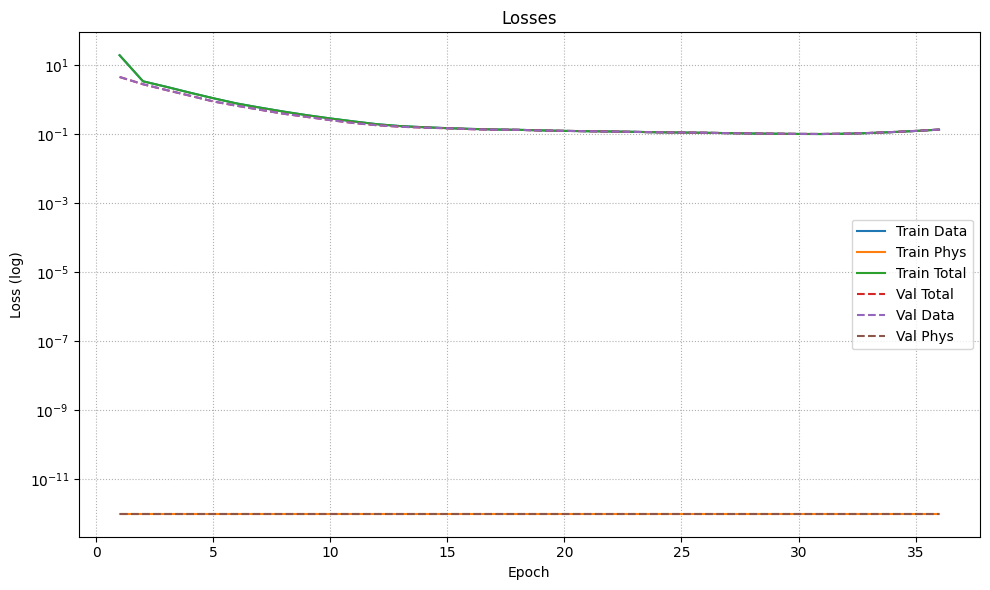

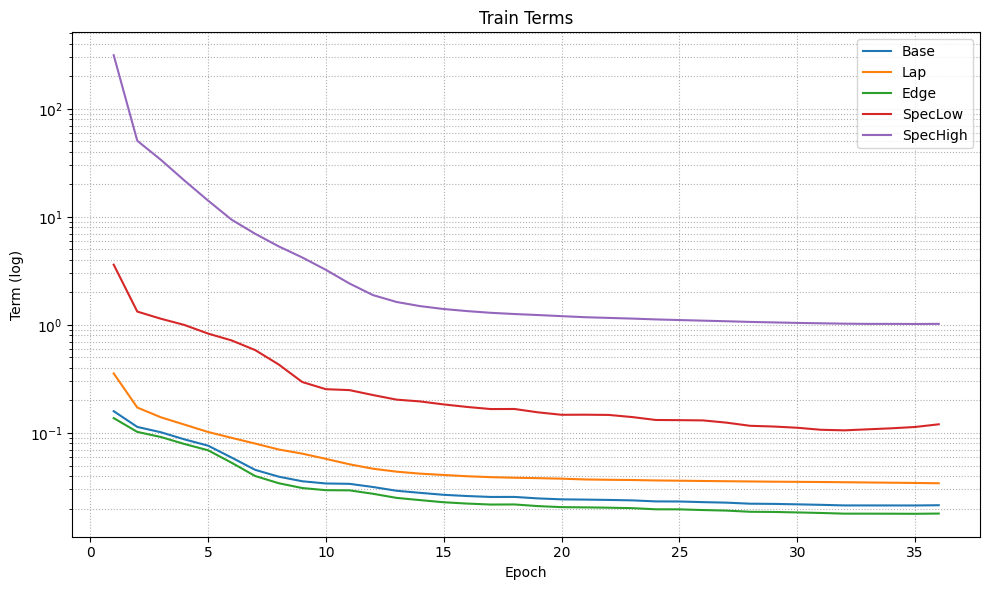

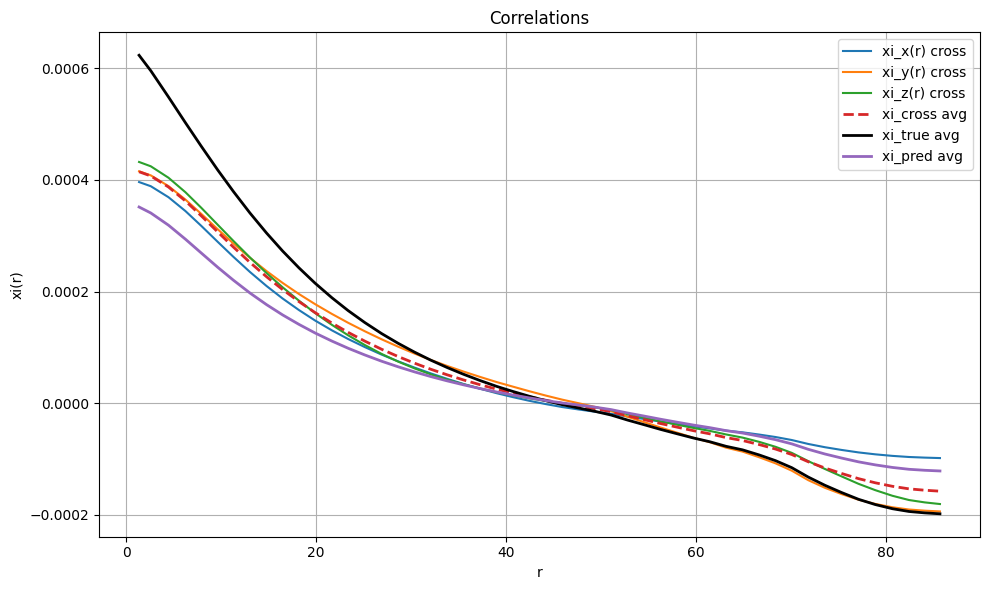

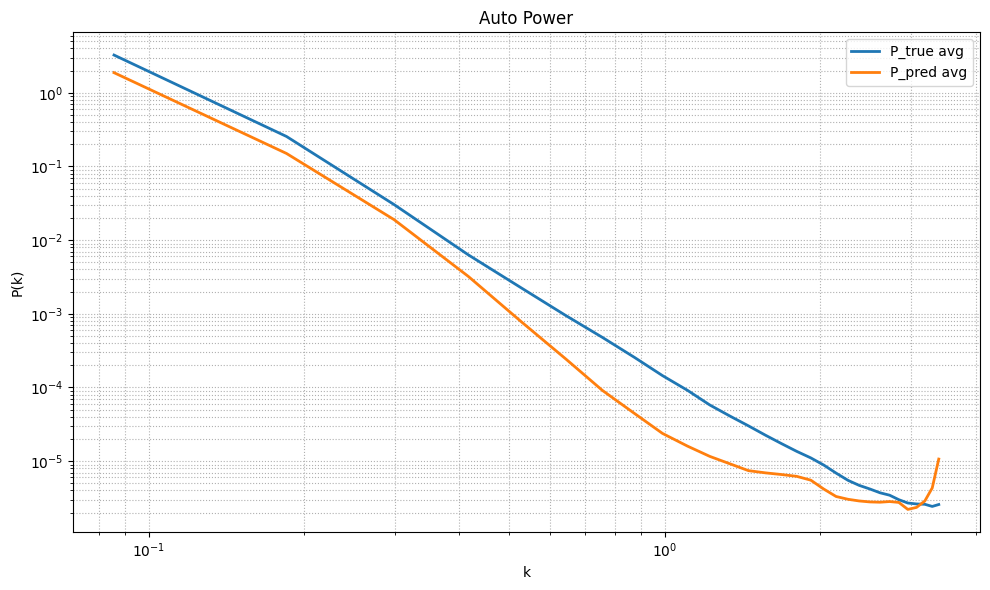

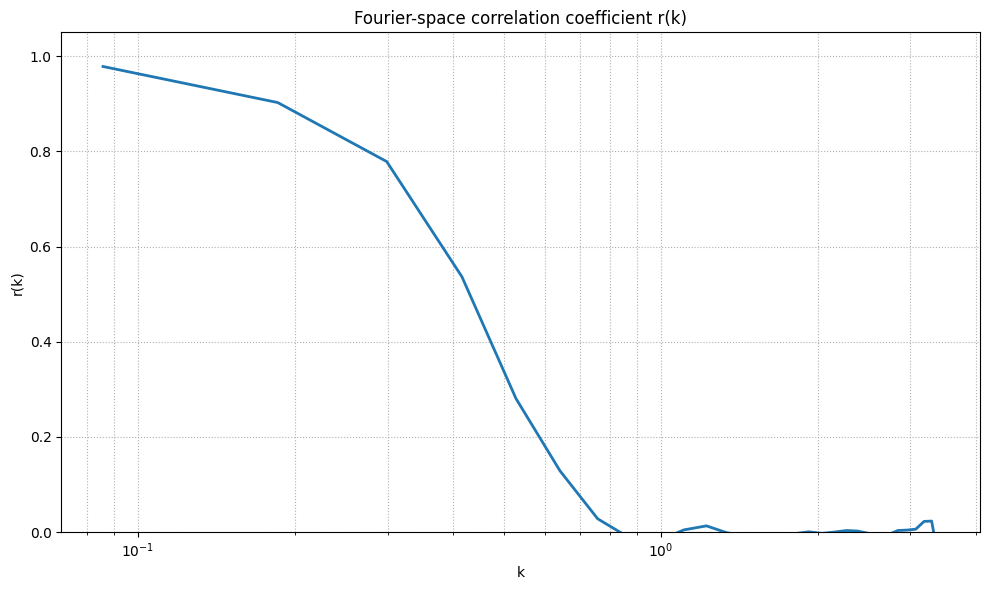

[slice] comp=0 z=32 real[min,max]=(-0.122,0.134) pred[min,max]=(-0.081,0.0935) diff[min,max]=(-0.0909,0.122) scale=(-0.134,0.134)


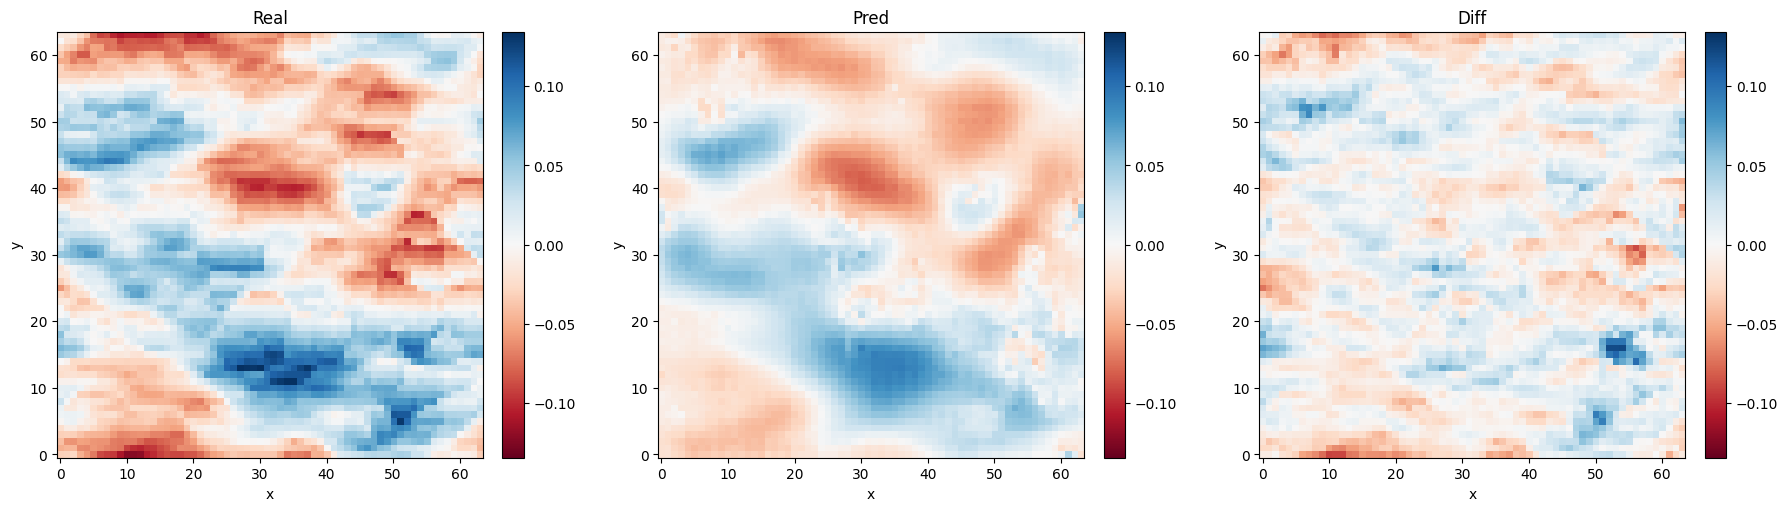

In [32]:
# Block 19: Viz
def cross_correlation_function(field_a, field_b, boxsize=100.0, nbins=50, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = Fa * np.conj(Fb) / V
    xi = np.fft.ifftn(Pab).real
    coords = np.fft.fftfreq(N) * N
    z, y, x = np.meshgrid(coords, coords, coords, indexing="ij")
    r_grid = np.sqrt(x**2 + y**2 + z**2) * (boxsize / N)
    r_flat = r_grid.reshape(-1); xi_flat = xi.reshape(-1)
    rmax = np.max(r_flat); bins = np.linspace(0.0, rmax, nbins + 1)
    which = np.digitize(r_flat, bins) - 1; nbins_eff = len(bins) - 1
    xi_sum = np.zeros(nbins_eff, dtype=np.float64)
    r_sum  = np.zeros(nbins_eff, dtype=np.float64)
    cnt    = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(r_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            xi_sum[bi] += xi_flat[i]; r_sum[bi] += r_flat[i]; cnt[bi] += 1
    mask  = cnt > 0
    r_bin = r_sum[mask] / cnt[mask]; xi_r = xi_sum[mask] / cnt[mask]
    return r_bin, xi_r

def _make_k_grid(N, boxsize):
    kf = 2.0 * np.pi / boxsize
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kx = kx * kf; ky = ky * kf; kz = kz * kf
    kk = np.sqrt(kx**2 + ky**2 + kz**2)
    return kx, ky, kz, kk

def power_spectrum_auto(field, boxsize=100.0, nbins=30, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean: a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a); V = boxsize ** 3
    P = (Fa * np.conj(Fa)).real / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = P.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def power_spectrum_cross(field_a, field_b, boxsize=100.0, nbins=30, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = (Fa * np.conj(Fb)) / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = Pab.real.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

if 'data_losses' not in globals() or not isinstance(data_losses, list) or len(data_losses) == 0:
    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location='cpu')
        data_losses       = ckpt.get('data_losses', [])
        phys_losses       = ckpt.get('phys_losses', [])
        total_losses      = ckpt.get('total_losses', [])
        base_disp_hist    = ckpt.get('base_disp_hist', [])
        lap_losses_hist   = ckpt.get('lap_losses_hist', [])
        edge_losses_hist  = ckpt.get('edge_losses_hist', [])
        spec_low_hist     = ckpt.get('spec_low_hist', [])
        spec_high_hist    = ckpt.get('spec_high_hist', [])
        val_data_losses   = ckpt.get('val_data_losses', [])
        val_phys_losses   = ckpt.get('val_phys_losses', [])
        val_total_losses  = ckpt.get('val_total_losses', [])
    else:
        data_losses = phys_losses = total_losses = []
        base_disp_hist = lap_losses_hist = edge_losses_hist = []
        spec_low_hist = spec_high_hist = []
        val_data_losses = val_phys_losses = val_total_losses = []

_EPS = 1e-12
def _safe_pos(seq):
    arr = np.array(seq, dtype=np.float64) if len(seq) else np.array([], dtype=np.float64)
    if arr.size: arr = np.maximum(arr, _EPS)
    return arr

epochs_list = list(range(1, len(data_losses) + 1))
plt.figure(figsize=(10, 6))
if len(data_losses): plt.semilogy(epochs_list, _safe_pos(data_losses), label='Train Data')
if len(phys_losses): plt.semilogy(epochs_list, _safe_pos(phys_losses), label='Train Phys')
if len(total_losses): plt.semilogy(epochs_list, _safe_pos(total_losses), label='Train Total')
if len(val_total_losses):
    ev = list(range(1, len(val_total_losses) + 1))
    plt.semilogy(ev, _safe_pos(val_total_losses), label='Val Total', linestyle='--')
if len(val_data_losses):
    evd = list(range(1, len(val_data_losses) + 1))
    plt.semilogy(evd, _safe_pos(val_data_losses), label='Val Data', linestyle='--')
if len(val_phys_losses):
    evp = list(range(1, len(val_phys_losses) + 1))
    plt.semilogy(evp, _safe_pos(val_phys_losses), label='Val Phys', linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('Loss (log)'); plt.title('Losses'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

have_terms = any(len(x) for x in [base_disp_hist, lap_losses_hist, edge_losses_hist, spec_low_hist, spec_high_hist])
if have_terms:
    plt.figure(figsize=(10, 6))
    if len(base_disp_hist):  plt.semilogy(range(1, len(base_disp_hist)+1),  _safe_pos(base_disp_hist),  label='Base')
    if len(lap_losses_hist): plt.semilogy(range(1, len(lap_losses_hist)+1), _safe_pos(lap_losses_hist), label='Lap')
    if len(edge_losses_hist):plt.semilogy(range(1, len(edge_losses_hist)+1),_safe_pos(edge_losses_hist),label='Edge')
    if len(spec_low_hist):   plt.semilogy(range(1, len(spec_low_hist)+1),   _safe_pos(spec_low_hist),   label='SpecLow')
    if len(spec_high_hist):  plt.semilogy(range(1, len(spec_high_hist)+1),  _safe_pos(spec_high_hist),  label='SpecHigh')
    plt.xlabel('Epoch'); plt.ylabel('Term (log)'); plt.title('Train Terms'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

if 'model' not in globals():
    try:
        model = UNet3D(pos_embed=pos_embed, use_cond=ROI_CONDITIONING).to(device)
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model: {best_model_path}")
        elif os.path.exists(checkpoint_path):
            ckpt = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            print(f"Loaded model from checkpoint: {checkpoint_path}")
        else:
            print("No model weights found.")
    except Exception as e:
        print(f"[warn] Model build failed: {e}")

if 'dataset' not in globals():
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=64, np_dtype=np.float16,
                         scale_disp=DISP_SCALE)

model.eval()
with torch.no_grad():
    try:
        rho_test, tilde_real = dataset[0]
    except Exception:
        ridx = np.random.randint(0, len(dataset))
        rho_test, tilde_real = dataset[ridx]
    rho_test = rho_test.unsqueeze(0).to(device, dtype=torch.float32)
    pred = model(rho_test)[0].cpu()
    tilde_real = tilde_real.cpu()

pred_np = pred.numpy().astype(np.float32)
real_np = tilde_real.numpy().astype(np.float32)

xi_cross_components = []; r_vals = None
for c in range(3):
    r, xi = cross_correlation_function(real_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_cross_components.append(xi)
    if r_vals is None: r_vals = r
xi_cross_avg = np.mean(np.stack(xi_cross_components, axis=0), axis=0)

xi_true_components = []
for c in range(3):
    _, xi_t = cross_correlation_function(real_np[c], real_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_true_components.append(xi_t)
xi_true_avg = np.mean(np.stack(xi_true_components, axis=0), axis=0)

xi_pred_components = []
for c in range(3):
    _, xi_p = cross_correlation_function(pred_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_pred_components.append(xi_p)
xi_pred_avg = np.mean(np.stack(xi_pred_components, axis=0), axis=0)

plt.figure(figsize=(10, 6))
for c, name in enumerate(['x', 'y', 'z']):
    plt.plot(r_vals, xi_cross_components[c], label=fr'xi_{name}(r) cross')
plt.plot(r_vals, xi_cross_avg, linestyle='--', linewidth=2.0, label='xi_cross avg')
plt.plot(r_vals, xi_true_avg, color='k', linewidth=2.0, label='xi_true avg')
plt.plot(r_vals, xi_pred_avg, linewidth=2.0, label='xi_pred avg')
plt.xlabel('r'); plt.ylabel('xi(r)'); plt.title('Correlations'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

NBINS_K = 30
Pk_true_components = []; Pk_pred_components = []; Pk_cross_components = []; k_vals = None
for c in range(3):
    k_t, Pt = power_spectrum_auto(real_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_p, Pp = power_spectrum_auto(pred_np[c],  boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_c, Pc = power_spectrum_cross(real_np[c], pred_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    Pk_true_components.append(Pt); Pk_pred_components.append(Pp); Pk_cross_components.append(Pc)
    if k_vals is None: k_vals = k_t
Pk_true_avg  = np.mean(np.stack(Pk_true_components, axis=0), axis=0)
Pk_pred_avg  = np.mean(np.stack(Pk_pred_components, axis=0), axis=0)
Pk_cross_avg = np.mean(np.stack(Pk_cross_components, axis=0), axis=0)
eps = 1e-20
rk = Pk_cross_avg / np.sqrt((Pk_true_avg + eps) * (Pk_pred_avg + eps))

plt.figure(figsize=(10, 6))
plt.loglog(k_vals, Pk_true_avg, label='P_true avg', linewidth=2.0)
plt.loglog(k_vals, Pk_pred_avg, label='P_pred avg', linewidth=2.0)
plt.xlabel('k'); plt.ylabel('P(k)'); plt.title('Auto Power'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(k_vals, rk, linewidth=2.0)
plt.ylim(0.0, 1.05)
plt.xlabel('k'); plt.ylabel('r(k)'); plt.title('Fourier-space correlation coefficient r(k)')
plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

component = 0
slice_idx = grid // 2
real_slice = real_np[component, :, :, slice_idx]
pred_slice = pred_np[component, :, :, slice_idx]
diff_slice = real_slice - pred_slice
v = float(np.max(np.abs([real_slice, pred_slice, diff_slice]))); v = max(v, 1e-6)
vmin, vmax = -v, v
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
im1 = axs[0].imshow(real_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[0].set_title('Real'); plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
im2 = axs[1].imshow(pred_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[1].set_title('Pred'); plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
im3 = axs[2].imshow(diff_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[2].set_title('Diff'); plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.set_xlabel('x'); ax.set_ylabel('y')
print(f"[slice] comp={component} z={slice_idx} real[min,max]=({real_slice.min():.3g},{real_slice.max():.3g}) "
      f"pred[min,max]=({pred_slice.min():.3g},{pred_slice.max():.3g}) "
      f"diff[min,max]=({diff_slice.min():.3g},{diff_slice.max():.3g}) "
      f"scale=({vmin:.3g},{vmax:.3g})")
plt.show()